In [6]:
# imports from resemblyzer demo01
from resemblyzer import preprocess_wav, VoiceEncoder
from itertools import groupby
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.axes_grid1 import make_axes_locatable

# my imports
import os


In [50]:
master_dir = '../audio/samples/edited/'

songs = ['justin_bieber-sorry', 'post_malone-white_iverson']

song_dirs = {song: os.path.join(master_dir, song) for song in songs}

# all of the wav file paths (starting from root dir)
wav_paths = {song: paths for song, paths in 
             [(song_name, [item for sublist in 
               [list(map(lambda x: os.path.join(master_dir, song_name, sample_name, x), 
                    os.listdir(os.path.join(master_dir, song_name, sample_name))))
                 for sample_name in os.listdir(os.path.join(master_dir, song_name))]
                           for item in sublist])
               for song_name in song_dirs
             ]}

print(wav_paths)

{'justin_bieber-sorry': ['../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+0.6.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+1.2.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+1.8.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+2.4.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+3.0.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch-0.6.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch-1.2.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch-1.8.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch-2.4.wav', '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch-3.0.wav', '../audio/samples/edited/

In [51]:
encoder = VoiceEncoder()

Loaded the voice encoder model on cpu in 0.07 seconds.


In [54]:
# Dict of the form {artist1: {filename1: wav1, filename2: wav2 ...}, artist2: {filename1: wav1, filename2: wav2 ...} ...
wavs = {artist:dict(wavs) for (artist, wavs) in 
        [(a, list(map(lambda x: (x,preprocess_wav(x)), wav_paths[a]))) for a in wav_paths]}
print(wavs)

{'justin_bieber-sorry': {'../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+0.6.wav': array([ 0.33508655,  1.0699562 ,  0.9722766 , ...,  0.1462821 ,
       -0.0486407 , -0.12926139], dtype=float32), '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+1.2.wav': array([ 0.33222908,  1.0761962 ,  0.96522486, ..., -0.21665141,
       -0.24252692, -0.20667619], dtype=float32), '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+1.8.wav': array([ 0.33919916,  1.0763893 ,  0.96492577, ..., -0.00114011,
       -0.16600233, -0.25736025], dtype=float32), '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+2.4.wav': array([ 0.35571143,  1.074005  ,  0.96673316, ..., -0.17710532,
       -0.10679448, -0.18110271], dtype=float32), '../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip13-vocals/pitch+3.0.wav': array([ 0.3582417 ,  1.064068  ,  0.97810924

In [55]:
# An embed is a vector of 256 values that summarizes the characteristics of the voice spoken
# (from https://github.com/resemble-ai/Resemblyzer)

# Dict of the form {artist1: {file1: embed1, file2: embed2 ...}, artist2: {file1: embed1, file2: embed2 ...} ...}
embeds = {artist:embeds for (artist, embeds) in 
         [(a, {f:np.array(encoder.embed_utterance(wav))
               for f,wav in wavs[a].items()}) for a in wavs]}


In [94]:
artists_to_compare = ('justin_bieber-sorry', 'post_malone-white_iverson')

similarities = {}
n = 0
#print(embeds)

for file1 in embeds[artist1]:
    #print(file1)
    for file2 in embeds[artist2]:
        if "0.0" in file1 or "0.0" in file2:
                similarities[(file1, file2)] = np.dot(embeds[artist1][file1], embeds[artist2][file2])

In [100]:
sorted_sims = sorted(similarities.items(), key=lambda x: x[1])

print(sorted_sims[-3])

(('../audio/samples/edited/justin_bieber-sorry/justin_bieber-sorry_snip17-vocals/pitch0.0.wav', '../audio/samples/edited/post_malone-white_iverson/post_malone-white_iverson_snip22-vocals/pitch+1.2.wav'), 0.80593246)


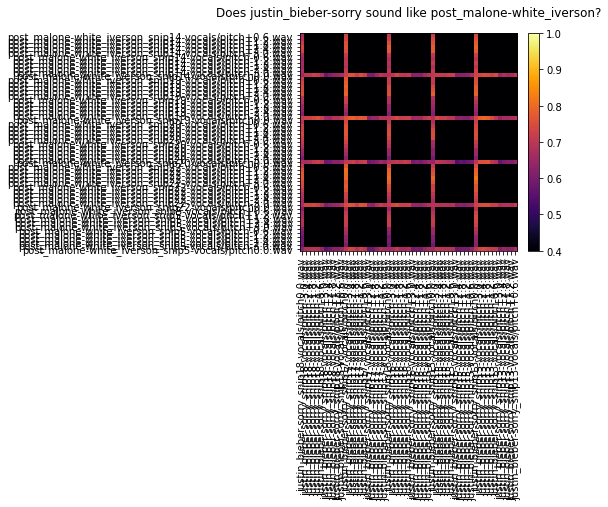

In [60]:
# Plot similarity matrix

artist1 = artists_to_compare[0]
artist2 = artists_to_compare[1]

# Compute and show a similarity matrix
#print(embeds)
'''matrix = np.array([[np.dot(embed1, embed2) for embed1 in 
                    
                    list(map(lambda x: x[1] if ("0.0" in x[0] or "0.0" in f) else np.array([0 for n in range(256)]), embeds[artist1].items()))
                   
                   ][::-1] for f,embed2 in embeds[artist2].items()])

'''matrix = np.array([[np.dot(embed1, embed2) for embed1 in 
                    
                    embeds[artist1].values()]
                   
                   for embed2 in embeds[artist2].values()])'''
#print(matrix)

get_name = lambda p : "/".join(p.split("/")[-2:])

x_labels = list(map(get_name,embeds[artist1].keys()))
y_labels = list(map(get_name, embeds[artist2].keys()))

_, ax = plt.subplots()
fig = plt.gcf()
img = ax.matshow(matrix, extent=(-0.5, matrix.shape[0] - 0.5, 
                                     -0.5, matrix.shape[1] - 0.5))

ax.xaxis.set_ticks_position("bottom")
ax.set_xticks(range(len(x_labels)))
ax.set_xticklabels(x_labels[::-1], rotation=90)

ax.set_yticks(range(len(y_labels)))
ax.set_yticklabels(y_labels[::-1])

ax.set_title("Does {0} sound like {1}?".format(artist1, artist2))

cax = make_axes_locatable(ax).append_axes("right", size="5%", pad=0.15)
fig.colorbar(img, cax=cax, ticks=np.linspace(0.4, 1, 7))
img.set_clim(0.4, 1)
img.set_cmap("inferno")
    
plt.show()

plt.close()

In [65]:
np.amax(matrix)

0.8203569650650024

In [314]:
"0.0" in "hello_0.0.wav"

True